In [10]:
from system import *
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import chain
import numpy as np
import pandas as pd
import random
import math
from tqdm import tqdm

In [2]:
class ReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []

    def push(self, transition):
        self.memory.append(transition)
        if len(self.memory) > self.capacity:
            del self.memory[0]

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [ ]:
sns.set()

In [3]:
e = TradingEnv()
STATE_DIM = len(e.reset())
print(f'STATE_DIM = {STATE_DIM}')
EMBED_DIM = 50 # from the dimensionality-reduced fastText model
ACTION_DIM = 3
EPISODES = 2000  # number of episodes
EPS_START = 0.9  # e-greedy threshold start value
EPS_END = 0.05  # e-greedy threshold end value
EPS_DECAY = 200  # e-greedy threshold decay
# GAMMA = 0.99  # Q-learning discount factor
LR = 0.001  # NN optimizer learning rate
HIDDEN_LAYER = 128  # NN hidden layer size
BATCH_SIZE = 16  # Q-learning batch size
TARGET_UPDATE = 100  # frequency of target update
BUFFER_SIZE = 100  # capacity of the replay buffer 

# if gpu is to be used
# use_cuda = torch.cuda.is_available()
use_cuda = False
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor  = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor  = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor
Tensor = FloatTensor
del e

STATE_DIM = 48


In [4]:
if use_cuda:
    print('GPU found and in use')
else:
    print('No GPU will be used')

No GPU will be used


# Simple QNetwork 
Corresponds to a fully connected network with two hidden layers

In [11]:
class QNetwork(nn.Module):
    def __init__(self):
        nn.Module.__init__(self)
        self.l1 = nn.Linear(STATE_DIM, HIDDEN_LAYER)
        self.l2 = nn.Linear(HIDDEN_LAYER, HIDDEN_LAYER)
        self.l3 = nn.Linear(HIDDEN_LAYER, ACTION_DIM)
                
    def forward(self, x):
        """
            Computes the estimated Q-values for a given batch x
        """
        x = F.leaky_relu(self.l1(x))
        x = F.leaky_relu(self.l2(x))
        x = self.l3(x)
        return x      
    
    def sample_from_softmax_policy(self, batch_state):
        batch_q_values = self.forward(batch_state)
        batch_pi = F.softmax(batch_q_values, dim=1)
        batch_size = batch_pi.shape[0]
        batch_actions = torch.empty(batch_size, 1)
        for i in range(batch_size):
            pi = batch_pi[i, :]
            dist = torch.distributions.Categorical(pi)
            # Subtract 1, so batch_actions is in {-1, 0, 1}
            batch_actions[i, 0] = dist.sample().view(1,1) - 1
        if use_cuda:
            batch_actions = batch_actions.to(batch_state.get_device())
        return batch_actions.long()

# Generic Training Agent

In [31]:
class BaseAgent:
    def __init__(self, gamma=0.8):
        assert 0 < gamma < 1, f"Invalid gamma: {gamma}" 
        self.gamma = gamma
        self.memory = ReplayMemory(BUFFER_SIZE)
        self.history = pd.DataFrame()
        self.rewards_history = []
        self.steps_done = 0
        with open('sp500.txt', 'r') as src:
            self.filtered_tickers = src.read().split(',')
        
    def run_episode(self, environment):
        """
            Takes an env, and trains the agent until the environment
            reaches a terminal state (ie the training window is complete).
            Must return environment.close()
        """
        raise NotImplementedError()
    
    def plot_cumulative_discounted_rewards(self):
        rl_data = self.history
        rl_data['discount_factor'] = np.power(self.gamma, rl_data.episode-1)
        rl_data['discounted_future_reward'] = rl_data['discount_factor'] * rl_data['rewards']
        rl_data = rl_data[['episode', 'discounted_future_reward']]
        rl_data = rl_data.groupby('episode').sum()
#         rl_plot = sns.lineplot(data=rl_data, legend=False)
        rl_data.plot(legend=False, title=f'Cumulative Discounted Rewards over Episodes')
        plt.ylabel('Cumulative Discounted Reward')
        plt.show()
        
    def convert_action(self, action):
        """
            Takes action of shape 1 x 3, and converts into an integer in {-1, 0, 1}.
            This integer is the position short/hold/long respectively.
        """
        position = action - 1
#         assert position in [-1,0,1]
        return position.item()
    
    def train(self, env_mode='train', num_tickers=20, num_episodes = 5):
        """
            Trains the agent for num_episodes episodes, looping over the approved
            list of tickers (filtered by num_tickers). This is a convenience function.
        """
        num_tickers = min(num_tickers, len(self.filtered_tickers))
        if num_tickers == np.Inf:
            num_tickers = len(self.filtered_tickers)
        self.history = pd.DataFrame()
        for i in tqdm(range(num_episodes)):
            ticker = self.filtered_tickers[ i % num_tickers ]
            env = TradingEnv(ticker=ticker, mode=env_mode)
            history = self.run_episode(env)
            history['ticker'] = ticker
            history['episode'] = i + 1
            self.history = pd.concat((self.history, history))
        self.history = self.history.reset_index('Date', drop=True)
#         self.plot_returns(num_tickers)
        self.plot_cumulative_discounted_rewards()
    
    def plot_returns(self, ticker):
        h = agent.history
        roi_data = h[h.ticker == ticker][['date','episode','returns']]
        plt.title(f'Returns for {ticker}')
        roi_plot = sns.lineplot(data=h, x='date', y='returns', hue='episode')
        roi_plot.set_xticklabels(roi_plot.get_xticklabels(), rotation=45);
    

        
class DQN(BaseAgent):
    def __init__(self):
        super().__init__()
        self.model = QNetwork()
        self.target = QNetwork()
        self.optimizer = optim.SGD(self.model.parameters(), LR)

    def select_epsilon_greedy_action(self, state):
        sample = random.random()
        eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * self.steps_done / EPS_DECAY)
        self.steps_done += 1
        greedy_action = None
        with torch.no_grad():
            greedy_action = self.model(state).data.argmax(dim=1).view(1,1)
        
        random_action = LongTensor([[random.randrange(ACTION_DIM)]])
        assert greedy_action.shape == random_action.shape, f"Incorrect sampling techinque {greedy_action.shape, random_action.shape}"
        if sample > eps_threshold:
            return greedy_action
        else:
            return random_action
    
    def run_episode(self, environment):
        state = environment.reset()
        steps = 0
        action = None
        while True:
            state_tensor = FloatTensor([state])
            action = self.select_epsilon_greedy_action(state_tensor)
            position = self.convert_action(action)
            next_state, reward, done, _ = environment.step(position)
            
            self.memory.push(
                (
                    FloatTensor([state]),
                    action,  # action is already a tensor
                    FloatTensor([next_state]),
                    FloatTensor([reward]),
                    FloatTensor([int(done)])
                )
            )

            self.learn()
            if self.steps_done % TARGET_UPDATE == 0:
                self.target.load_state_dict(self.model.state_dict())
        
            state = next_state
            steps += 1
            if done:
                break
        history = environment.close()
        return history

    def max_next_q_values(self, batch_next_state):
        # expected Q values are estimated from actions which gives maximum Q value
        return self.target(batch_next_state).detach().max(1)[0]
    
    def learn(self):
        if len(self.memory) <= BATCH_SIZE:
            return
        # random transition batch is taken from experience replay memory
        transitions = self.memory.sample(BATCH_SIZE)
        batch_state, batch_action, batch_next_state, batch_reward, batch_done = zip(*transitions)
        batch_state = Variable(torch.cat(batch_state))
        batch_action = Variable(torch.cat(batch_action))
        batch_reward = Variable(torch.cat(batch_reward))
        batch_next_state = Variable(torch.cat(batch_next_state))
        batch_done = Variable(torch.cat(batch_done))

        # current Q values are estimated by NN for all actions
        current_q_values = self.model(batch_state).gather(1, batch_action).squeeze()
        expected_future_rewards = self.max_next_q_values(batch_next_state)
        
        expected_q_values = batch_reward + (self.gamma * expected_future_rewards) * (1 - batch_done)

        # loss is measured from error between current and newly expected Q values
        loss = F.mse_loss(current_q_values, expected_q_values)

        # backpropagation of loss to QNetwork
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


# agent=DQN()
# env = TradingEnv()
# for i in range(10):
#     s = FloatTensor([env.reset()])
#     agent.steps_done=100
#     print(agent.select_epsilon_greedy_action(s))

# agent.run_episode(env)

100%|██████████| 20/20 [00:42<00:00,  2.14s/it]


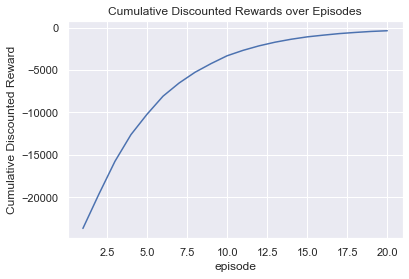

In [41]:
dqn_agent = DQN()
dqn_agent.train(num_tickers=1, num_episodes=20)

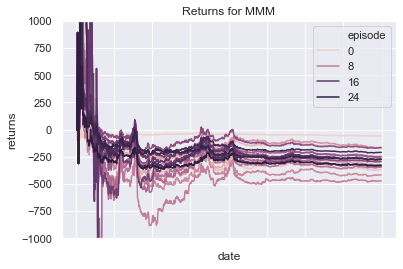

In [42]:
plt.ylim(-1000,1000)
dqn_agent.plot_returns('MMM')

In [ ]:
rl_data = dqn_agent.history
rl_data['discount_factor'] = np.power(dqn_agent.gamma, rl_data.episode-1)
rl_data['discounted_future_reward'] = rl_data['discount_factor'] * rl_data['rewards']
rl_data = rl_data[['episode', 'discounted_future_reward']]
# rl_data.columns
rl_data = rl_data.groupby('episode').sum()
# rl_data
# rl_plot = sns.lineplot(data=rl_data, legend=False)

In [ ]:
rl_data.plot(legend=False, title=f'Cumulative Discounted Rewards over Episodes')
plt.ylabel('Cumulative Discounted Reward')
plt.show()

In [ ]:
plt.title(f'Cumulative Discounted Rewards for {ticker}')
rl_plot = sns.lineplot(data=rl_data, legend=False)
# sns.legend(False)
# roi_plot.set_xticklabels(roi_plot.get_xticklabels(), rotation=45);

In [25]:
h = agent.history
ticker='MMM'

[]

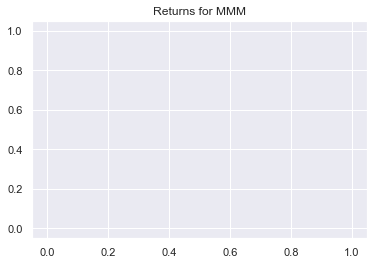

In [30]:
import seaborn as sns
# fg=sns.FacetGrid(data=h, hue='episode', aspect=1.61)
# fg.map(plt.plot)

# roi_plot = sns.tsplot(data=h, x='date', y='returns', hue='episode')
# roi_plot.set_xticklabels(roi_plot.get_xticklabels(), rotation=45);
# h.plot()
# roi_plot.show()
# plt.plot()

In [ ]:
# %load_ext line_profiler

In [ ]:
# e = TradingEnv()

In [ ]:
# %lprun -f agent.learn [agent.run_episode(e) for _ in range(10)]

In [ ]:
# _ = e.reset()
# %lprun -f e.step e.step(1)

# Policy Network

In [37]:
class PolicyNetwork(nn.Module):
    # for Policy-Gradient methods, e.g. actor-only and actor-critic methods
    def __init__(self):
        nn.Module.__init__(self)
        self.l1 = nn.Linear(STATE_DIM, HIDDEN_LAYER)
        self.l2 = nn.Linear(HIDDEN_LAYER, HIDDEN_LAYER)
        self.l3 = nn.Linear(HIDDEN_LAYER, ACTION_DIM) # 2, for the action

    def forward(self, x, get_log=False):
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        if not get_log:
            x = F.softmax(self.l3(x), dim=1)
        else:
            x = F.log_softmax(self.l3(x), dim=1)
        return x

    def sample_from_softmax_policy(self, batch_state):
        batch_pi = self.forward(batch_state)
        batch_size = batch_pi.shape[0]
        actions = torch.empty(batch_size, 1)
        for i in range(batch_size):
            pi = batch_pi[i, :]
            dist = torch.distributions.Categorical(pi)
            actions[i, 0] = dist.sample().view(1,1)
        if use_cuda:
            actions = actions.to(batch_state.get_device())
        return actions.long()

# p = PolicyNetwork()
# state = env.reset()
# state_tensor = FloatTensor([state]).cuda()
# p.cuda()
# p.forward(state_tensor, d=1), p.forward(state_tensor, d=-1)
# p.sample_from_softmax_policy(torch.cat(5*[state_tensor])).shape

# LongOnly Agent

In [43]:
class LongOnlyAgent(BaseAgent):
    def __init__(self):
        super().__init__()
        
    def run_episode(self, environment):
        state = environment.reset()
        steps = 0
        position = 1
        while True:
            _, r, done, __ = environment.step(position)

            self.steps_done += 1
            steps += 1
            if done:
                break
        self.rewards_history.append(environment.rewards_list)
        return environment.close()

# long_agent = LongOnlyAgent()
# e = TradingEnv()
# long_agent.run_episode(e)
# # long_agent.rewards_history
# long_agent.run_episode(e)

In [44]:
long_agent = LongOnlyAgent()

100%|██████████| 20/20 [00:19<00:00,  1.04it/s]


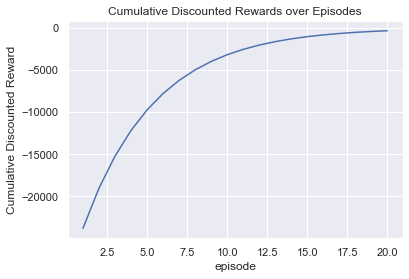

In [45]:
long_agent.train(num_tickers=1, num_episodes=20)

In [46]:
long_agent.history

,date,ticker,rewards,actions,returns,prices,episode,discount_factor,discounted_future_reward
0,2014-01-06,MMM,-0.075815,1,5.815700,137.630005,1,1.000000,-0.075815
1,2014-01-07,MMM,-27.923206,1,-290.944802,137.649994,1,1.000000,-27.923206
2,2014-01-08,MMM,-7.871890,1,-343.317175,136.630005,1,1.000000,-7.871890
3,2014-01-09,MMM,-11.663949,1,-421.873515,136.449997,1,1.000000,-11.663949
4,2014-01-10,MMM,-45.344489,1,-858.290718,136.179993,1,1.000000,-45.344489
...,...,...,...,...,...,...,...,...,...
20095,2017-12-22,MMM,-3.073729,1,28460.218243,234.729996,20,0.014412,-0.044297
20096,2017-12-26,MMM,-5.720505,1,28678.426845,235.449997,20,0.014412,-0.082441
20097,2017-12-27,MMM,-26.316168,1,28538.774583,236.199997,20,0.014412,-0.379256
20098,2017-12-28,MMM,-31.930738,1,28436.942126,235.720001,20,0.014412,-0.460170


In [47]:
dqn_agent.history

,date,ticker,rewards,actions,returns,prices,episode,discount_factor,discounted_future_reward
0,2014-01-06,MMM,-0.488206,-1,-5.815700,137.630005,1,1.000000,-0.488206
1,2014-01-07,MMM,-4.851185,0,-2.909086,137.649994,1,1.000000,-4.851185
2,2014-01-08,MMM,-0.000000,0,-2.909086,136.630005,1,1.000000,-0.000000
3,2014-01-09,MMM,-7.878143,1,-28.553995,136.449997,1,1.000000,-7.878143
4,2014-01-10,MMM,-5.696929,0,-21.324762,136.179993,1,1.000000,-5.696929
...,...,...,...,...,...,...,...,...,...
20095,2017-12-22,MMM,-11.404279,-1,-589.804183,234.729996,20,0.014412,-0.164353
20096,2017-12-26,MMM,-14.494776,-1,-590.164951,235.449997,20,0.014412,-0.208892
20097,2017-12-27,MMM,-19.516262,-1,-589.936441,236.199997,20,0.014412,-0.281259
20098,2017-12-28,MMM,-23.637053,-1,-589.768712,235.720001,20,0.014412,-0.340646


# A2C

In [48]:
class A2C(BaseAgent):
    def __init__(self):
        super().__init__()
        self.policy = PolicyNetwork()
        self.model = QNetwork()
        self.optimizer = optim.Adam(chain(self.model.parameters(),
                                          self.policy.parameters()), LR)

        
    def temporal_diff(self, state, action, next_state, reward):
        state_tensor = FloatTensor([state])
        next_state_tensor = FloatTensor([next_state])
        with torch.no_grad():
            q = self.model(state_tensor).gather(1, action)
            future_q = reward + self.gamma * self.model(next_state_tensor).max(dim=1)[0]
            return future_q - q
        
        
    def get_adv(self, state, action, next_state, reward):
        state_tensor = FloatTensor([state])
        next_state_tensor = FloatTensor([next_state])

        with torch.no_grad():
            future_q = reward + self.gamma * self.model(next_state_tensor).max(dim=1)[0]
            pi = self.policy(state_tensor).squeeze(0)
            q_values = self.model(state_tensor).squeeze(0)
            return future_q - torch.dot(q_values, pi)
    
    
    def run_episode(self, environment):
        state = environment.reset()
        steps = 0
        action = None
        while True:
            if steps % 100 == 0:
                print(f'steps = {steps}')
            state_tensor = FloatTensor([state])
            try:
                action = self.policy.sample_from_softmax_policy(state_tensor)
            except RuntimeError:
                print(f'state = {state_tensor}')
                print(f'policy = {self.policy(state_tensor)}')
                raise
            position = self.convert_action(action)
            next_state, reward, done, _ = environment.step(position)
            self.learn(state, action, next_state, reward)
            state = next_state
            steps += 1
            if done:
                break
        history = environment.close()
        return history


    def learn(self, state, action, next_state, reward):
        n = self.steps_done
        state_tensor = FloatTensor([state])

        delta = self.temporal_diff(state, action, next_state, reward)
        q_loss = delta * self.model(state_tensor).gather(1, action)

        A = self.get_adv(state, action, next_state, reward)
        pi_a = self.policy(state_tensor).gather(1, action)
        policy_loss = A * torch.log(pi_a)

        loss = (self.gamma ** n) * (policy_loss + q_loss)

        # backpropagation of loss to QNetwork and PolicyNetwork
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


In [ ]:
a2c_agent = A2C()
a2c_agent.train(env_mode="train", num_tickers=1, num_episodes=20)

  0%|          | 0/20 [00:00<?, ?it/s]

steps = 0
steps = 100
steps = 200
steps = 300
steps = 400
steps = 500


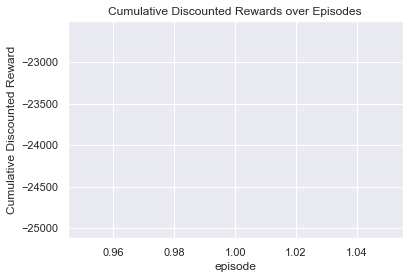

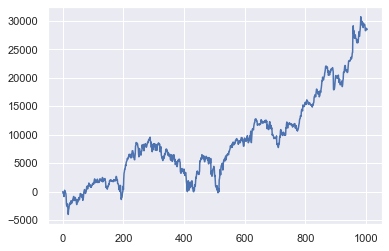

In [56]:
a2c_agent.plot_cumulative_discounted_rewards()
a2c_agent.history['returns'].plot()

In [ ]:
e = TradingEnv()
s0 = FloatTensor([e.reset()])

In [ ]:
a2c_agent.policy.sample_from_softmax_policy(s0)
# a2c_agent.policy(s0).sum()

In [ ]:
a2c_agent.policy

 # Model-based (using Reddit Comments)

In [ ]:
class ModelBasedAgent(BaseAgent):
    def __init__(self):
        super().__init__()